In [1]:
#Import Libraries
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
#from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation


c = 3.0  # mementun generator constant
k_x = 1.0*(2*c-1)*np.pi  # wave constant along x-axis
k_y = 1.0*(2*c-1)*np.pi  # wave constant along x-axis
m = 1.0 # mass of the particle
h_bar = 1.0 # universal constant h-cross


# Simulation space parameters
L = 24 # Length of cube space
Dy = 0.05 # Spatial step size. # Dy= Dz=Dx
Dt = Dy**2/4 # Temporal step size.
Nx = int(L/Dy) + 1 # Number of points on the x axis.
Ny = int(L/Dy) + 1 # Number of points on the y axis.

Nt = 800# Number of time steps.1000
rx = -Dt/(2j*Dy**2) # Constant to simplify expressions.
ry = -Dt/(2j*Dy**2) # Constant to simplify expressions.
# Initial position of the center of the Gaussian wave function.
x0 = 1*0.5
y0 = 100*0.05
#x0 = 60*0.05
#y0 = 0.6 #(240-160+0.707*90)*0.05

Ni = (Nx-2)*(Ny-2)  # Number of unknown factors v[i,j], i = 1,...,Nx-2, j = 1,...,Ny-2

def psi_0(x,y,x_0,y_0,sigma=0.3,k_y=k_y,k_x=k_x):
    Norm1D=1/((2*np.pi*sigma*sigma)**(0.25))
    #waveFn1=Norm1D*np.exp(-1/2*((x-x_0)**2 + (y-y_0)**2)/sigma**2)*np.exp(1j*k_y*(y-y_0))*np.exp(1j*k_x*(x-x_0))
    waveFn1=Norm1D*np.exp(-1/2*((x-x_0-7.5)**2 + (y-y_0)**2)/sigma**2)*np.exp(1j*k_y*(y-y_0))*np.exp(-1j*k_x*(x-x_0-7.0))
    waveFn2=Norm1D*np.exp(-1/2*((x-x_0-7.5)**2 + (y-y_0)**2)/sigma**2)*np.exp(1j*k_y*(y- y_0))*np.exp(+1j*k_x*(x-x_0-7.0))
    return waveFn1+waveFn2
    #return np.exp(1j*k_x*(x-x_0)*np.exp(1j*k_y*(y-y_0)))


# Defining the potential

Fill the 2D array called space with potentials as you see fit
We have set potentials for mach zander experiment and commented values which can be used for changing the transmission and reflection probabilities.

space[x][y] = potential at coordinate(x,y)

V1= (100+0j)


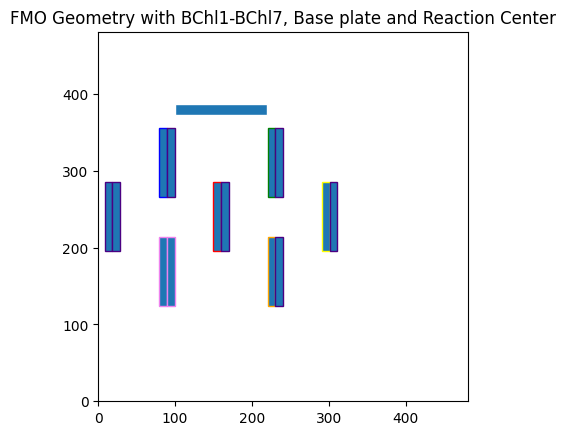

<Figure size 640x480 with 0 Axes>

In [2]:
# classical potentials around the BChl proteins
# Vx is left part and Vx_5 is right part of the mirror
V1 = 100  + 0j#8.464*(k_x*k_x + k_y*k_y)/(2*m*h_bar)   # 50% transmission and reflection probability
V1_5 = 200  + 0j#8.464*(k_x*k_x + k_y*k_y)/(2*m*h_bar)   # 50% transmission and reflection probability
V2 = 600 + 0j#2*8.464*(k_x*k_x + k_y*k_y)/(2*m*h_bar) # 100% reflection probability
V2_5 = 100  + 0j
V3 = 200  + 0j#8.464*(k_x*k_x + k_y*k_y)/(2*m*h_bar)   # 50% transmission and reflection probability
V3_5 = 100  + 0j
V4 = 100  + 0j#8.464*(k_x*k_x + k_y*k_y)/(2*m*h_bar)   # 50% transmission and reflection probability
V4_5 = 200  + 0j
V5 = 100 + 0j#2*8.464*(k_x*k_x + k_y*k_y)/(2*m*h_bar) # 100% transmission and reflection probability
V5_5 = 600  + 0j
V6 = 200  + 0j#8.464*(k_x*k_x + k_y*k_y)/(2*m*h_bar)   # 50% transmission and reflection probability
V6_5 = 100  + 0j
V7 = 600 + 0j#2*8.464*(k_x*k_x + k_y*k_y)/(2*m*h_bar) # 100% transmission and reflection probability
V7_5 = 600  + 0j
print("V1=",V1)


# BChl-1 to BChl-6 are assumed as rectangular potential barriers,
# BChl-2, BChl-5 and BChl-7 are zero tunneling reflectors,
# Parameters of BChl proteins
height  = 90 # length of protein molecule
width = 20  # thickness of protein molecule, if you change width, center should be updated
# six Bchl proteins are arranged around a peripheri of a circle, equally spaced
# Bchl-7 is located at the center
radius = 100

#########################################
# Define the matrix size and initialize with zeros
space = np.zeros((Nx, Ny), dtype=complex)

# Initialize the array with random complex values for adding noise

real_part = np.random.uniform(0, 10, (Nx, Ny))  # Random values for the real part
imaginary_part = np.random.uniform(0, 0, (Nx, Ny))  # Random values for the imaginary part
space = real_part + 1j * imaginary_part


def get_rectangle(center, width, height):

    # Define the half-dimensions
    half_width = width / 2
    half_height = height / 2


    corners = np.array([
        [-half_width, -half_height],
        [half_width, -half_height],
        [half_width, half_height],
        [-half_width, half_height]
    ])

    displaced_corners = corners + center

    return displaced_corners

def points_in_polygon(polygon, grid_size):
    x, y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
    points = np.vstack((x.ravel(), y.ravel())).T
    path = Path(polygon)
    mask = path.contains_points(points)
    return mask.reshape((grid_size, grid_size)).T

# Define the center of BChl proteins
center1    = np.array([160-0.707*radius-width/4, 80+160-0.707*radius])
center1_5  = np.array([160-0.707*radius+width/4, 80+160-0.707*radius])
center2    = np.array([160-1.414*radius-width/4, 80+160])
center2_5  = np.array([160-1.414*radius+width/4, 80+160])
center3    = np.array([160-0.707*radius-width/4, 80+160+0.707*radius])
center3_5  = np.array([160-0.707*radius+width/4, 80+160+0.707*radius])
center4    = np.array([160+0.707*radius-width/4, 80+160+0.707*radius])
center4_5  = np.array([160+0.707*radius+width/4, 80+160+0.707*radius])
center5    = np.array([160+1.414*radius-width/4, 80+160])
center5_5  = np.array([160+1.414*radius+width/4, 80+160])
center6    = np.array([160+0.707*radius-width/4, 80+160-0.707*radius])
center6_5  = np.array([160+0.707*radius+width/4, 80+160-0.707*radius])
center7    = np.array([160-width/4, 80+160])
center7_5  = np.array([160+width/4, 80+160])
#centerRC   = np.array([160+2.0*radius, 80+160+0.5*radius])
centerRC   = np.array([160, 80+3*radius])

# Get the corners of the protein rectangular barriers
rectangle_corners1 = get_rectangle(center1, width/2, height)
# print(center1,width,height,rectangle_corners1)
rectangle_corners1_5 = get_rectangle(center1_5, width/2, height)
rectangle_corners2 = get_rectangle(center2, width/2, height)
rectangle_corners2_5 = get_rectangle(center2_5, width/2, height)
rectangle_corners3 = get_rectangle(center3, width/2, height)
rectangle_corners3_5 = get_rectangle(center3_5, width/2, height)
rectangle_corners4 = get_rectangle(center4, width/2, height)
rectangle_corners4_5 = get_rectangle(center4_5, width/2, height)
rectangle_corners5 = get_rectangle(center5, width/2, height)
rectangle_corners5_5 = get_rectangle(center5_5, width/2, height)
rectangle_corners6 = get_rectangle(center6, width/2, height)
rectangle_corners6_5 = get_rectangle(center6_5, width/2, height)
rectangle_corners7 = get_rectangle(center7, width/2, height)
rectangle_corners7_5 = get_rectangle(center7_5, width/2, height)
#rectangle_cornersRC = get_rectangle(centerRC, width+100, height, angle-45)
rectangle_cornersRC = get_rectangle(centerRC, width+100, 15)


# Determine which points are inside the rotated rectangle
mask1 = points_in_polygon(rectangle_corners1, Nx)
mask1_5 = points_in_polygon(rectangle_corners1_5, Nx)
mask2 = points_in_polygon(rectangle_corners2, Nx)
mask2_5 = points_in_polygon(rectangle_corners2_5, Nx)
mask3 = points_in_polygon(rectangle_corners3, Nx)
mask3_5 = points_in_polygon(rectangle_corners3_5, Nx)
mask4 = points_in_polygon(rectangle_corners4, Nx)
mask4_5 = points_in_polygon(rectangle_corners4_5, Nx)
mask5 = points_in_polygon(rectangle_corners5, Nx)
mask5_5 = points_in_polygon(rectangle_corners5_5, Nx)
mask6 = points_in_polygon(rectangle_corners6, Nx)
mask6_5 = points_in_polygon(rectangle_corners6_5, Nx)
mask7 = points_in_polygon(rectangle_corners7, Nx)
mask7_5 = points_in_polygon(rectangle_corners7_5, Nx)

# Fill the complex matrix values inside the rectangle
space[mask1] = V1
space[mask1_5] = V1_5
space[mask2] = V2
space[mask2_5] = V2_5
space[mask3] = V3
space[mask3_5] = V3_5
space[mask4] = V4
space[mask4_5] = V4_5
space[mask5] = V5
space[mask5_5] = V5_5
space[mask6] = V6
space[mask6_5] = V6_5
space[mask7] = V7
space[mask7_5] = V7_5

# Plot the matrix and the rotated rectangle
# plt.figure(figsize=(6, 6))
# plt.imshow(np.abs(space), extent=[0, Nx, 0, Ny], origin='lower', cmap='gray')
# plt.colorbar(label='Magnitude')
polygon1    = Polygon(rectangle_corners1, closed=True, edgecolor='violet', fill='blue')
polygon1_5  = Polygon(rectangle_corners1_5, closed=True, edgecolor='violet', fill='red')
polygon2    = Polygon(rectangle_corners2, closed=True, edgecolor='indigo', fill='blue')
polygon2_5  = Polygon(rectangle_corners2_5, closed=True, edgecolor='indigo', fill='red')
polygon3    = Polygon(rectangle_corners3, closed=True, edgecolor='blue', fill='blue')
polygon3_5  = Polygon(rectangle_corners3_5, closed=True, edgecolor='indigo', fill='red')
polygon4    = Polygon(rectangle_corners4, closed=True, edgecolor='green', fill='blue')
polygon4_5  = Polygon(rectangle_corners4_5, closed=True, edgecolor='indigo', fill='red')
polygon5    = Polygon(rectangle_corners5, closed=True, edgecolor='yellow', fill='blue')
polygon5_5  = Polygon(rectangle_corners5_5, closed=True, edgecolor='indigo', fill='red')
polygon6    = Polygon(rectangle_corners6, closed=True, edgecolor='orange', fill='blue')
polygon6_5  = Polygon(rectangle_corners6_5, closed=True, edgecolor='indigo', fill='red')
polygon7    = Polygon(rectangle_corners7, closed=True, edgecolor='red', fill='blue')
polygon7_5  = Polygon(rectangle_corners7_5, closed=True, edgecolor='indigo', fill='red')
polygonRC = Polygon(rectangle_cornersRC, closed=True, edgecolor='white', fill='blue')
plt.gca().add_patch(polygon1)
plt.gca().add_patch(polygon1_5)
plt.gca().add_patch(polygon2)
plt.gca().add_patch(polygon2_5)
plt.gca().add_patch(polygon3)
plt.gca().add_patch(polygon3_5)
plt.gca().add_patch(polygon4)
plt.gca().add_patch(polygon4_5)
plt.gca().add_patch(polygon5)
plt.gca().add_patch(polygon5_5)
plt.gca().add_patch(polygon6)
plt.gca().add_patch(polygon6_5)
plt.gca().add_patch(polygon7)
plt.gca().add_patch(polygon7_5)
plt.gca().add_patch(polygonRC)
plt.xlim(0, Nx)
plt.ylim(0, Ny)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('FMO Geometry with BChl1-BChl7, Base plate and Reaction Center')
plt.show()
plt.savefig('FMOgeometry.png')


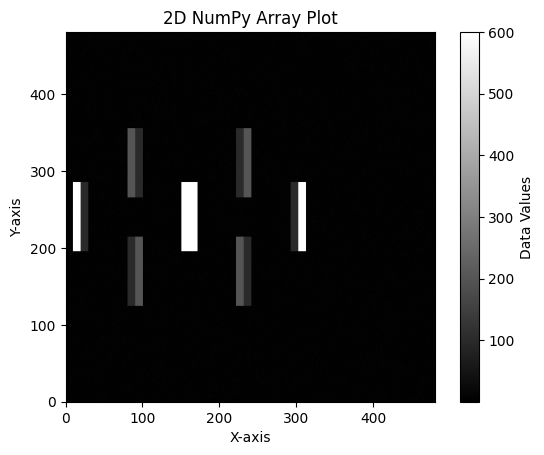

In [3]:
import matplotlib.pyplot as plt
plt.figure()  # Create a new figure window
plt.imshow(abs(space).T,extent=(0, space.shape[0], 0, space.shape[1]), origin='lower',cmap="gray")  # Plot the data as an image (adjust 'cmap' for colormaps)
plt.colorbar(label="Data Values")  # Add a colorbar to represent data intensity
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("2D NumPy Array Plot")
plt.show()

# Creating the A and M matrix for Crank Nicolson for 2D

In [4]:
import scipy as sp
A = np.zeros((Ni), complex)
M = np.zeros((Ni), complex)

# We fill the A and M matrices.
for k in range(Ni):

    # k = (i-1)*(Ny-2) + (j-1)
    i = 1 + k//(Ny-2)
    j = 1 + k%(Ny-2)

    # Main central diagonal.
    A[k] = 1 + 2*rx + 2*ry + 1j*Dt/2*space[i,j]
    M[k] = 1 - 2*rx - 2*ry - 1j*Dt/2*space[i,j]
diag = np.ones([Ni])
diags1 = np.array([-rx*diag, -ry*diag,  A*diag, -ry*diag, -rx*diag])
diags2 = np.array([rx*diag, ry*diag, M*diag, ry*diag, rx*diag])

# Construct sparse matrices
A = sparse.spdiags(diags1, np.array([-(Nx-2), -1, 0, 1, (Nx-2)]), Ni, Ni)
M = sparse.spdiags(diags2, np.array([-(Nx-2), -1, 0, 1, (Nx-2)]), Ni, Ni)

print(A.shape)
print(M.shape)

A = A.tocsr()
M = M.tocsr()

(229441, 229441)
(229441, 229441)


# Solving Crank Nicolson Matrix

In [5]:
# =============================================================================
# Second step: Solve the A·x[n+1] = M·x[n] system for each time step.
# =============================================================================

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from tqdm import tqdm
# Asp = csc_matrix(A)

x = np.linspace(0, L, Ny-2) # Array of spatial points.
y = np.linspace(0, L, Ny-2) # Array of spatial points.
X, Y = np.meshgrid(x, y,indexing='ij')
# print(x)
# print("\n")
# print(y)
# print("\n")
psis = [] # To store the wave function at each time step.

psi = psi_0(X, Y, x0, y0) # We initialise the wave function with the Gaussian.
# psi = np.array(psi)
# psi=np.rot90(psi, k=1)
print(type(psi),psi.shape)
psi[0,:] = psi[-1,:] = psi[:,0] = psi[:,-1] = 0 # The wave function equals 0 at the edges of the simulation box (infinite potential well).
psis.append(np.copy(psi)) # We store the wave function of this time step.

for i in tqdm(range(1, Nt), desc="Progress"):

    psi_vect = psi.reshape(Ni)
    psi_vect = np.array(psi_vect)
    b = M.dot(psi_vect) # Calculate the array of independent terms
    psi_vect = spsolve(A, b)  # Solve the system for this temporal step
    psi = psi_vect.reshape(Nx-2, Ny-2, )  # Reshape the array to the shape of the wave function
    psis.append(psi)  # Save the result


mod_psis = [abs(wavefunc) for wavefunc in psis]


<class 'numpy.ndarray'> (479, 479)


Progress: 100%|██████████| 799/799 [5:27:23<00:00, 24.59s/it]


# Plotting the movement of particles

Streaming output truncated to the last 5000 lines.
not equal
11 11.245841909980882 2.6841879909506585 0.005055016968082935 -0.010689746029759162 (0.004761938122110799-0.002649960993048556j)
not equal
0 10.662344806529683 2.188539093489022 0.0014419791898696147 -0.011969811433225454 (0.0021333344687368945-0.00041166015983855347j)
not equal
1 10.23729464847915 3.0006607457794248 -0.004061600261390817 -0.0014141862843255154 (-2.2657272863985933e-05+0.00027947402844849734j)
not equal
2 10.931143584529373 2.1492601401177427 0.0031219678022805725 -0.011980068678129943 (-0.00017296152684410836+0.002050126804766165j)
not equal
3 10.480597180022949 2.83215411988485 6.794405037971449e-05 -0.002911976274112425 (-0.0004822455792583626+0.00027045594528555725j)
not equal
4 10.082688346357385 1.6248515028529704 0.002950003597690556 -0.011331840104179884 (-0.0002337224229368506-0.00177192321452196j)
not equal
5 4.850249848897911 3.054167535202635 0.0006190428709418496 -0.010071937207864297 (-0.0053423

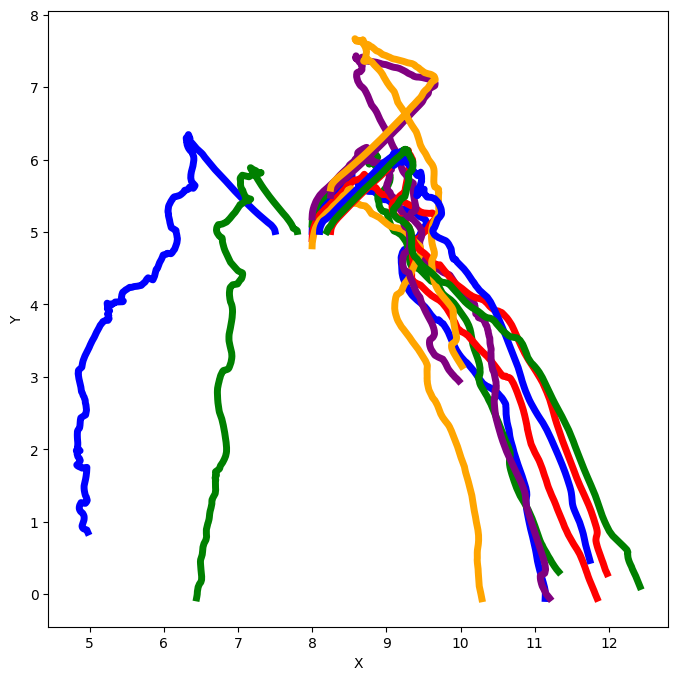

{0: {'x': [8.0, 8.000067562366524, 8.000246604484621, 8.000592001235335, 8.001135923076367, 8.001877623043859, 8.0029806084401, 8.004297885079874, 8.005828911566276, 8.007562299238016, 8.0094738677889, 8.011542419301351, 8.013738687632188, 8.016062641052185, 8.018529897229136, 8.02117492287265, 8.024012725945042, 8.026625640396443, 8.02941586602533, 8.03236904315571, 8.035439969698082, 8.038583331441833, 8.041765741264284, 8.045024003073586, 8.048341875376964, 8.051738126003212, 8.05667075653541, 8.061717892973787, 8.066901179211236, 8.072237284657495, 8.077754394030155, 8.083484690037901, 8.089447775460776, 8.095732643569233, 8.102198611656075, 8.110676985020682, 8.11917926669574, 8.127650915601185, 8.135892960071168, 8.144018778284918, 8.152018868879052, 8.163115811114075, 8.174326869967317, 8.185932639087971, 8.19756415690511, 8.209205748773146, 8.218408636151851, 8.227247459237049, 8.236163321245696, 8.24489978402492, 8.25349917003519, 8.264340343831853, 8.275292728766054, 8.285783

[[11.140108581649432, -0.05869493755954855],
 [11.321235934471641, 0.30981734659511484],
 [11.8392273242751, -0.05658856497872111],
 [11.199209196747717, -0.054952474355699735],
 [10.28704971897025, -0.0628659168828739],
 [4.975655966829225, 0.8561893733891687],
 [6.443194320497141, -0.05161705870309679],
 [11.97403200120082, 0.28407854988253317],
 [9.975729770897852, 2.945594093983529],
 [10.017044891710643, 3.148986870641614],
 [11.742654313722758, 0.46595813722458773],
 [12.417596816462348, 0.10491181839710542]]

<Figure size 640x480 with 0 Axes>

In [6]:
######################################################

# Initialize particle positions (assuming L is defined)
px0=np.float64(x0+7.5)
py0=np.float64(y0)
particle_position = [[px0, py0], [px0, py0+0.1], [px0, py0-0.1], [px0, py0+0.2],[px0, py0-0.2], [px0-0.5, py0], [px0-0.2, py0], [px0+0.25, py0], [px0+0.25, py0+0.5], [px0+0.25, py0+0.6], [px0+0.1, py0], [px0+0.2, py0]]
num_particles = len(particle_position) # Replace with the actual number of particles

e=1e-20 # to avoid divided by zero

# Assuming psis is defined elsewhere and contains wavefunction values
print(particle_position,len(psis))
# Dictionaries to store particle positions (generalized)
particle_data = {i: {'x': [], 'y': []} for i in range(num_particles)}
# print(wavefunc.shape)
# Simulate particle movement
count=0
for wavefunc in psis:
    for k, particle in enumerate(particle_position):
        # print(wavefunc.shape)
        i = int(particle[0] / Dy)
        j = int(particle[1] / Dy)
        # print("no",i,j)
        # print("enterinnner loop",wavefunc.shape)
        if (0 <= i < wavefunc.shape[0] and 0 <= j < wavefunc.shape[1]):
            Rx = (wavefunc[i + 1, j] - wavefunc[i, j])/Dy
            Ry = (wavefunc[i, j + 1] - wavefunc[i, j])/Dy

        else:
            continue  # Skip particle movement for those outside the grid

        # if(i<0 or j<0):
        #     continue

        # elif(i<wavefunc.shape[0] and j<wavefunc.shape[1]): # originally it was 157 instead of Nx-3, Ny-3
            # Rx = (wavefunc[i, j] - wavefunc[i-1, j])/Dy
            # Ry = (wavefunc[i, j] - wavefunc[i, j-1])/Dy
            # print("yes",i,j)
        # elif(i<0 or j<0):
        #     print("yes",i,j)
            # print("entering")
        # else:
        #     continue

        if(wavefunc[i,j]==0):
            wavefunc[i,j]=5  #just test
            # continue
        Rx = Rx / (wavefunc[i, j] + e)
        Ry = Ry / (wavefunc[i, j] + e)
        # print(wavefunc[i,j])
        # if (wavefunc[i,j]==0):
        #     print(0)

        Rx = Dt * Rx.imag
        Ry = Dt * Ry.imag
        if(particle[0]!=(particle[0]+Rx)):
            print("not equal")

        particle[0] += Rx
        particle[1] += Ry

        # if(k==14):
        print(k,particle[0],particle[1],Rx,Ry,wavefunc[i,j])
        # print(k,particle[0],particle[1])
        # Append positions to dictionaries
        particle_data[k]['x'].append(particle[0])
        particle_data[k]['y'].append(particle[1])


# Plot particle movement with different colors
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Adjust colors as needed
plt.figure(figsize=(8, 8))  # Set figure size for better visualization



# Loop through particle data and plot trajectories
for i, particle in particle_data.items():
    label = f'Particle {i+1}'  # Adjust label format if needed
    plt.plot(particle['x'], particle['y'], label=label, color=colors[i % len(colors)],linewidth=5)  # Cycle through colors

# plt.xlim(0, 8)  # Keep the same limits for the new orientation
# plt.ylim(-8, 0)  # Swap and negate limits to create a 90-degree rotation

# # Swap labels to match the new orientation
# plt.xlabel('Y', labelpad=10)  # Add labelpad for better positioning
# plt.ylabel('X', labelpad=10)

plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()
plt.show()
plt.savefig('trajectory.png')

print(particle_data)

particle_position


# Animating the wave function

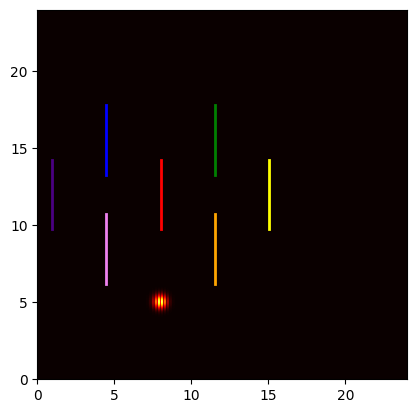

In [7]:

##########################################
# =============================================================================
# Third step: We make the animation.
# =============================================================================

fig = plt.figure() # We create the figure.
ax = fig.add_subplot(111, xlim=(0,L), ylim=(0,L)) # We add the subplot to the figure.
img = ax.imshow(mod_psis[1], extent=[0,L,0,L], cmap=plt.get_cmap("hot"), vmin=0, vmax=np.max(mod_psis), zorder=1, origin='lower') # Here the modulus of the 2D wave function shall be represented.

# Initialize a line
#line, = ax.plot([], [], lw=2)
# Add a small static line segment
small_line1, = ax.plot([], [], lw=2, color='violet')
small_line2, = ax.plot([], [], lw=2, color='indigo')
small_line3, = ax.plot([], [], lw=2, color='blue')
small_line4, = ax.plot([], [], lw=2, color='green')
small_line5, = ax.plot([], [], lw=2, color='yellow')
small_line6, = ax.plot([], [], lw=2, color='orange')
small_line7, = ax.plot([], [], lw=2, color='red')
small_lineBP, = ax.plot([], [], lw=2, color='white')
small_lineRC, = ax.plot([], [], lw=2, color='white')


# We define the animation function for FuncAnimation.

def animate(i):


    """
    Animation function. Paints each frame. Function for Matplotlib's
    FuncAnimation.
    """

    img.set_data(mod_psis[i].T) # Fill img with the modulus data of the wave function.
    img.set_zorder(1)

    # center1  = np.array([160-0.707*radius, 80+160-0.707*radius])
    BChl1_x =  [0.05*(160-0.707*radius), 0.05*(160-0.707*radius)]
    BChl1_y =  [0.05*(80+160-0.707*radius+height/2), 0.05*(80+160-0.707*radius-height/2)]
    small_line1.set_data(BChl1_x, BChl1_y)

    # center2  = np.array([160-1.414*radius, 80+160])
    BChl2_x =  [0.05*(160-1.414*radius), 0.05*(160-1.414*radius)]
    BChl2_y =  [0.05*(80+160+height/2), 0.05*(80+160-height/2)]
    small_line2.set_data(BChl2_x, BChl2_y)

    # center3  = np.array([160-0.707*radius, 80+160+0.707*radius])
    BChl3_x =  [0.05*(160-0.707*radius), 0.05*(160-0.707*radius)]
    BChl3_y =  [0.05*(80+160+0.707*radius+height/2), 0.05*(80+160+0.707*radius-height/2)]
    small_line3.set_data(BChl3_x, BChl3_y)

    # center4  = np.array([160+0.707*radius, 80+160+0.707*radius])
    BChl4_x =  [0.05*(160+0.707*radius), 0.05*(160+0.707*radius)]
    BChl4_y =  [0.05*(80+160+0.707*radius+height/2), 0.05*(80+160+0.707*radius-height/2)]
    small_line4.set_data(BChl4_x, BChl4_y)

    # center5  = np.array([160+1.414*radius, 80+160])
    BChl5_x =  [0.05*(160+1.414*radius), 0.05*(160+1.414*radius)]
    BChl5_y =  [0.05*(80+160+height/2), 0.05*(80+160-height/2)]
    small_line5.set_data(BChl5_x, BChl5_y)

    # center6  = np.array([160+0.707*radius, 80+160-0.707*radius])
    BChl6_x =  [0.05*(160+0.707*radius), 0.05*(160+0.707*radius)]
    BChl6_y =  [0.05*(80+160-0.707*radius+height/2), 0.05*(80+160-0.707*radius-height/2)]
    small_line6.set_data(BChl6_x, BChl6_y)


    # center7  = np.array([160       , 80+160])
    BChl7_x =  [0.05*(160), 0.05*(160)]
    BChl7_y =  [0.05*(80+160+height/2), 0.05*(80+160-height/2)]
    small_line7.set_data(BChl7_x, BChl7_y)

    # centerRC = np.array([160+2.0*radius, 80+160+0.5*radius])


    return img, # We return the result ready to use with blit=True.



########## gif file......

ani = animation.FuncAnimation(fig, animate, repeat=False,
                                    frames=np.arange(0,Nt,2), interval=1)
writer = animation.PillowWriter(fps=20,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
ani.save('scatter.gif', writer=writer)